# Exploratory Data Analysis (EDA)
## Predicting AI Acceptance in Mental Health Interventions through Self-Determination Theory

This notebook creates two clean, analysis-ready datasets:
1. **CN_all_coalesced.csv** - China data with all composite scores
2. **merged.csv** - Combined USA + China data ready for hypothesis testing

### Research Questions:
- **H1**: Main Effect - SDT predicts AI Acceptance
- **H2**: Attitudinal Moderation - AI attitudes moderate SDT → AI Acceptance relationship
- **H3**: Cross-Cultural Moderation - Effects stronger in China vs US
- **H4**: Mediation by Epistemic Trust - Epistemic Trust mediates SDT → AI Acceptance

## 0. Library Import

In [1]:
from __future__ import annotations

import warnings
from pathlib import Path
from typing import List, Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

DATA_DIR = Path("data")
MERGED_DIR = DATA_DIR / "merged"
CHINA_DIR = DATA_DIR / "china"
USA_DIR = DATA_DIR / "usa"

MERGED_DIR.mkdir(parents=True, exist_ok=True)

## 1. Load and Prepare China Data

China has three separate files that need to be coalesced:
- CN_all.csv - Combined sample
- CN_client.csv - Client-specific items
- CN_therapist.csv - Therapist-specific items

In [2]:
cn_all = pd.read_csv(CHINA_DIR / "CN_all.csv")
cn_client = pd.read_csv(CHINA_DIR / "CN_client.csv")
cn_therapist = pd.read_csv(CHINA_DIR / "CN_therapist.csv")

print(f"CN_all: {cn_all.shape}")
print(f"CN_client: {cn_client.shape}")
print(f"CN_therapist: {cn_therapist.shape}")

CN_all: (485, 514)
CN_client: (216, 565)
CN_therapist: (269, 565)


### 1.1 Merge Client and Therapist Data into CN_all

Client and therapist files have additional items not in CN_all. We'll merge them in.

In [3]:
# Find columns unique to client/therapist files
all_cols = set(cn_all.columns)
client_cols = set(cn_client.columns)
ther_cols = set(cn_therapist.columns)

# Columns that exist in client/therapist but not in all
missing_from_all = sorted(list((client_cols | ther_cols) - all_cols))

print(f"Found {len(missing_from_all)} columns to add from client/therapist files")
print(f"Examples: {missing_from_all[:5]}")

Found 53 columns to add from client/therapist files
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean']


In [4]:
# Get columns that overlap between client and therapist
overlap_cols = sorted(list(set(missing_from_all).intersection(client_cols).intersection(ther_cols)))
print(f"{len(overlap_cols)} columns exist in both client and therapist files")

53 columns exist in both client and therapist files


In [5]:
# Prepare client and therapist data for merging
# Add suffixes to distinguish source
client_extra_cols = [c for c in missing_from_all if c in cn_client.columns]
therapist_extra_cols = [c for c in missing_from_all if c in cn_therapist.columns]

# Create separate dataframes with just ID and the extra columns
client_extra = cn_client[["ID"] + client_extra_cols].copy()
therapist_extra = cn_therapist[["ID"] + therapist_extra_cols].copy()

# Add suffixes to overlapping columns
client_extra = client_extra.rename(columns={c: f"{c}_client" for c in client_extra_cols})
therapist_extra = therapist_extra.rename(columns={c: f"{c}_therapist" for c in therapist_extra_cols})

# Merge into cn_all
cn_augmented = cn_all.merge(client_extra, on="ID", how="left")
cn_augmented = cn_augmented.merge(therapist_extra, on="ID", how="left")

print(f"Augmented CN_all from {cn_all.shape} to {cn_augmented.shape}")

Augmented CN_all from (485, 514) to (485, 620)


In [6]:
cn_augmented.head()

,ID,responsetime,workinmh,workinmh_text,mh_service,receive_mh_service,age,gender,ethnicity,province,...,chatbot_CO_mean_therapist,chatbot_EOU_mean_therapist,chatbot_HC_mean_therapist,chatbot_HM_mean_therapist,chatbot_PPR_mean_therapist,chatbot_SE_mean_therapist,chatbot_TQE_mean_therapist,chatbot_mean_therapist,stagesAI_mean_therapist,therapist_filter_therapist
0,380.0,3853.0,2.0,NaN,1.0,2.0,10.0,3.0,0.0,陕西省,...,3.0,3.5,2.75,4.0,2.5,3.5,3.666667,3.273810,4.428395,0.0
1,269.0,1778.0,2.0,NaN,1.0,1.0,17.0,3.0,0.0,上海市,...,5.0,5.0,2.00,5.0,1.0,5.0,5.000000,4.000000,5.000000,0.0
2,73.0,1810.0,2.0,NaN,1.0,2.0,2.0,3.0,0.0,黑龙江省,...,2.0,3.0,3.00,3.0,3.0,2.0,3.000000,2.714286,3.352469,0.0
3,544.0,2001.0,1.0,NaN,2.0,2.0,7.0,3.0,0.0,北京市,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,415.0,1523.0,2.0,NaN,1.0,1.0,1.0,3.0,0.0,内蒙古自治区,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.2 Coalesce Client/Therapist Columns

For columns that exist in both client and therapist versions, we'll coalesce them into single unified columns.

In [7]:
# Create coalesced versions of overlapping columns
cn_coalesced = cn_augmented.copy()

# Get list of base names that have both _client and _therapist versions
client_suffix_cols = [c for c in cn_coalesced.columns if c.endswith("_client")]
therapist_suffix_cols = [c for c in cn_coalesced.columns if c.endswith("_therapist")]

# Find base names that exist in both
client_bases = {c.replace("_client", "") for c in client_suffix_cols}
therapist_bases = {c.replace("_therapist", "") for c in therapist_suffix_cols}
common_bases = sorted(list(client_bases & therapist_bases))

# For each paired column, create a unified version
for base in common_bases:
    client_col = f"{base}_client"
    therapist_col = f"{base}_therapist"
    
    # Coalesce: use client value if available, otherwise therapist value
    cn_coalesced[base] = cn_coalesced[client_col].fillna(cn_coalesced[therapist_col])

print(f"Created {len(common_bases)} coalesced columns")
print(f"Examples: {common_bases[:5]}")

Created 53 coalesced columns
Examples: ['AI_use_sum', 'AIavatar_CO_mean', 'AIavatar_EOU_mean', 'AIavatar_HC_mean', 'AIavatar_HM_mean']


### 1.3 Add role_label Variable

Identify whether each participant is a therapist or client based on which version has data.

In [8]:
# Determine role based on which file the participant came from
# Check if they have data in client-specific or therapist-specific columns
if 'therapist' in cn_coalesced.columns:
    # If there's already a therapist column, use it
    cn_coalesced['role_label'] = cn_coalesced['therapist'].map({1: 'therapist', 0: 'client'})
else:
    # Infer from which suffixed columns have data
    # Check a sample client-only column to see who has data
    sample_client_col = f"{common_bases[0]}_client" if common_bases else None
    sample_ther_col = f"{common_bases[0]}_therapist" if common_bases else None
    
    if sample_client_col and sample_ther_col:
        cn_coalesced['role_label'] = 'unknown'
        cn_coalesced.loc[cn_coalesced[sample_client_col].notna(), 'role_label'] = 'client'
        cn_coalesced.loc[cn_coalesced[sample_ther_col].notna(), 'role_label'] = 'therapist'

if 'role_label' in cn_coalesced.columns:
    print("Role distribution:")
    print(cn_coalesced['role_label'].value_counts())
else:
    print("Could not determine role_label")

Role distribution:
role_label
therapist    269
client       216
Name: count, dtype: int64


### 1.4 Compute Composite Scores for China

Calculate mean scores for all multi-item scales.

In [9]:
#  1. TENS_Life_mean (Self-Determination - 9 items, first 6 are reverse-coded)
tens_items = ['TENS_Life_1r', 'TENS_Life_2r', 'TENS_Life_3r', 'TENS_Life_4r', 'TENS_Life_5r', 'TENS_Life_6r',
              'TENS_Life_7', 'TENS_Life_8', 'TENS_Life_9']
tens_available = [c for c in tens_items if c in cn_coalesced.columns]
if tens_available:
    cn_coalesced['TENS_Life_mean'] = cn_coalesced[tens_available].mean(axis=1)
    print(f"TENS_Life_mean: {len(tens_available)}/9 items, Mean={cn_coalesced['TENS_Life_mean'].mean():.2f}")

# 2. ET_mean (Epistemic Trust - 15 items)
et_items = [f'ET_{i}' for i in range(1, 16)]
et_available = [c for c in et_items if c in cn_coalesced.columns]
if et_available:
    cn_coalesced['ET_mean'] = cn_coalesced[et_available].mean(axis=1)
    print(f"ET_mean: {len(et_available)}/15 items, Mean={cn_coalesced['ET_mean'].mean():.2f}")

# 3. SSRPH_mean (Stigma - 5 items)
ssrph_items = [f'SSRPH_{i}' for i in range(1, 6)]
ssrph_available = [c for c in ssrph_items if c in cn_coalesced.columns]
if ssrph_available:
    cn_coalesced['SSRPH_mean'] = cn_coalesced[ssrph_available].mean(axis=1)
    print(f"SSRPH_mean: {len(ssrph_available)}/5 items, Mean={cn_coalesced['SSRPH_mean'].mean():.2f}")

# 4. PHQ5_mean (Depression - 5 items)
phq_items = [f'PHQ5_{i}' for i in range(1, 6)]
phq_available = [c for c in phq_items if c in cn_coalesced.columns]
if phq_available:
    cn_coalesced['PHQ5_mean'] = cn_coalesced[phq_available].mean(axis=1)
    print(f"PHQ5_mean: {len(phq_available)}/5 items, Mean={cn_coalesced['PHQ5_mean'].mean():.2f}")

# 5. GAAIS_mean (General AI Attitudes - using existing GAAIS_pos and GAAIS_neg if available)
if 'GAAIS_pos' in cn_coalesced.columns and 'GAAIS_neg' in cn_coalesced.columns:
    # Overall is average of positive and (reversed) negative
    cn_coalesced['GAAIS_mean'] = (cn_coalesced['GAAIS_pos'] + (8 - cn_coalesced['GAAIS_neg'])) / 2
    print(f"GAAIS_mean: computed from pos/neg subscales, Mean={cn_coalesced['GAAIS_mean'].mean():.2f}")
elif 'GAAIS_mean' not in cn_coalesced.columns:
    # Compute from individual items
    gaais_items = [f'GAAIS_{i}' for i in range(1, 11)]
    gaais_available = [c for c in gaais_items if c in cn_coalesced.columns]
    if gaais_available:
        cn_coalesced['GAAIS_mean'] = cn_coalesced[gaais_available].mean(axis=1)
        print(f"GAAIS_mean: {len(gaais_available)} items, Mean={cn_coalesced['GAAIS_mean'].mean():.2f}")

# 6. UTAUT_AI_mean (AI Acceptance - 26 items)
utaut_ai_items = [f'UTAUT_AI{i}' for i in range(1, 27)]
# Also check for reversed items
utaut_ai_items_with_r = []
for i in range(1, 27):
    if f'UTAUT_AI{i}r' in cn_coalesced.columns:
        utaut_ai_items_with_r.append(f'UTAUT_AI{i}r')
    elif f'UTAUT_AI{i}' in cn_coalesced.columns:
        utaut_ai_items_with_r.append(f'UTAUT_AI{i}')

if utaut_ai_items_with_r:
    cn_coalesced['UTAUT_AI_mean'] = cn_coalesced[utaut_ai_items_with_r].mean(axis=1)
    print(f"UTAUT_AI_mean: {len(utaut_ai_items_with_r)} items, Mean={cn_coalesced['UTAUT_AI_mean'].mean():.2f}")

print("All composite scores computed for China")

TENS_Life_mean: 9/9 items, Mean=4.35
ET_mean: 15/15 items, Mean=4.70
SSRPH_mean: 5/5 items, Mean=2.30
PHQ5_mean: 5/5 items, Mean=1.53
GAAIS_mean: computed from pos/neg subscales, Mean=4.57
UTAUT_AI_mean: 26 items, Mean=3.64
All composite scores computed for China


### 1.4b Compute UTAUT Subscales for China

Compute 7 UTAUT factors based on item content and theoretical constructs:
1. **EOU** (Ease of Use) - Items 1-4
2. **SI** (Social Influence) - Items 7-9
3. **CONV** (Convenience) - Items 10-12
4. **HC** (Human Connection) - Items 13-14, 22
5. **PPR** (Privacy Risk) - Items 16-21 (reversed)
6. **HM** (Hedonic Motivation) - Items 23-24 (reversed)
7. **TQE** (Therapy Quality Expectancy) - Items 25-26

In [10]:
def compute_utaut_subscales(df, prefix="UTAUT_AI"):
    """
    Compute UTAUT subscales for a given prefix (e.g., UTAUT_AI, UTAUT_chatbot, UTAUT_human)
    
    Args:
        df: DataFrame containing UTAUT items
        prefix: Prefix for UTAUT items (e.g., 'UTAUT_AI', 'UTAUT_chatbot')
    
    Returns:
        DataFrame with added subscale columns
    """
    subscale_mapping = {
        f"{prefix}_EOU_mean": [1, 2, 4],  # Ease of Use
        f"{prefix}_SI_mean": [7, 8, 9],  # Social Influence
        f"{prefix}_CONV_mean": [10, 11, 12],  # Convenience
        f"{prefix}_HC_mean": [13, 14, 22],  # Human Connection
        f"{prefix}_PPR_mean": [16, 17, 18, 19, 20, 21],  # Privacy Risk (reversed)
        f"{prefix}_HM_mean": [23, 24],  # Hedonic Motivation (reversed)
        f"{prefix}_TQE_mean": [25, 26],  # Therapy Quality Expectancy
    }
    
    results = {}
    
    for subscale_name, item_nums in subscale_mapping.items():
        # Build list of column names for this subscale
        cols = []
        for num in item_nums:
            # Check for reversed version first
            if f"{prefix}{num}r" in df.columns:
                cols.append(f"{prefix}{num}r")
            elif f"{prefix}{num}" in df.columns:
                cols.append(f"{prefix}{num}")
        
        if cols:
            df[subscale_name] = df[cols].mean(axis=1)
            results[subscale_name] = len(cols)
    
    return df, results

print("Computing UTAUT subscales for China...\n")

Computing UTAUT subscales for China...



In [11]:
# Compute subscales for each UTAUT version in China data
utaut_versions = ['UTAUT_AI', 'UTAUT_chatbot', 'UTAUT_human']

all_results = {}
for version in utaut_versions:
    # Check if this version exists in the data
    version_cols = [c for c in cn_coalesced.columns if c.startswith(version)]
    if version_cols:
        cn_coalesced, results = compute_utaut_subscales(cn_coalesced, prefix=version)
        all_results[version] = results
        print(f"{version}: Computed {len(results)} subscales")
        for sub, n_items in results.items():
            mean_val = cn_coalesced[sub].mean()
            print(f"  {sub:30} {n_items} items, M={mean_val:.2f}")
        print()

print(f"\nTotal UTAUT subscales created: {sum(len(r) for r in all_results.values())}")

UTAUT_AI: Computed 7 subscales
  UTAUT_AI_EOU_mean              3 items, M=3.50
  UTAUT_AI_SI_mean               3 items, M=3.66
  UTAUT_AI_CONV_mean             3 items, M=3.85
  UTAUT_AI_HC_mean               3 items, M=3.87
  UTAUT_AI_PPR_mean              6 items, M=3.57
  UTAUT_AI_HM_mean               2 items, M=3.58
  UTAUT_AI_TQE_mean              2 items, M=3.74

UTAUT_chatbot: Computed 7 subscales
  UTAUT_chatbot_EOU_mean         3 items, M=3.58
  UTAUT_chatbot_SI_mean          3 items, M=3.71
  UTAUT_chatbot_CONV_mean        3 items, M=3.83
  UTAUT_chatbot_HC_mean          3 items, M=3.90
  UTAUT_chatbot_PPR_mean         6 items, M=3.58
  UTAUT_chatbot_HM_mean          2 items, M=3.55
  UTAUT_chatbot_TQE_mean         2 items, M=3.77

UTAUT_human: Computed 7 subscales
  UTAUT_human_EOU_mean           3 items, M=3.61
  UTAUT_human_SI_mean            3 items, M=3.71
  UTAUT_human_CONV_mean          3 items, M=3.83
  UTAUT_human_HC_mean            3 items, M=3.81
  UTAUT_human_P

In [12]:
# Recompute overall UTAUT_AI_mean from subscales (if subscales exist)
utaut_subscale_cols = [c for c in cn_coalesced.columns if 'UTAUT_' in c and c.endswith('_mean') and 
                       any(factor in c for factor in ['EOU', 'SI', 'CONV', 'HC', 'PPR', 'HM', 'TQE'])]

if utaut_subscale_cols:
    # Use AI version subscales for overall mean
    ai_subscales = [c for c in utaut_subscale_cols if 'UTAUT_AI' in c]
    if ai_subscales:
        cn_coalesced['UTAUT_AI_mean_from_subscales'] = cn_coalesced[ai_subscales].mean(axis=1)
        print(f"Recomputed UTAUT_AI_mean from {len(ai_subscales)} subscales")
        print(f"Mean: {cn_coalesced['UTAUT_AI_mean_from_subscales'].mean():.2f}")
        print(f"Correlation with original UTAUT_AI_mean: {cn_coalesced[['UTAUT_AI_mean', 'UTAUT_AI_mean_from_subscales']].corr().iloc[0,1]:.3f}")
else:
    print("No UTAUT subscales found")

Recomputed UTAUT_AI_mean from 7 subscales
Mean: 3.68
Correlation with original UTAUT_AI_mean: 0.973


### 1.5 Add Country Label and Export China Data

In [13]:
# Add Country column
cn_coalesced['Country'] = 'China'

# Export to CSV
output_path = CHINA_DIR / "CN_all_coalesced.csv"
cn_coalesced.to_csv(output_path, index=False)

print("CHINA DATA COMPLETE")
print(f"Saved: {output_path}")
print(f"Shape: {cn_coalesced.shape}")
print(f"Participants: {len(cn_coalesced)}")
print(f"Variables: {len(cn_coalesced.columns)}")

CHINA DATA COMPLETE
Saved: data/china/CN_all_coalesced.csv
Shape: (485, 701)
Participants: 485
Variables: 701


In [14]:
# Show key composites
key_composites = ['TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean']
available_composites = [c for c in key_composites if c in cn_coalesced.columns]
print(f"Key composite scores ({len(available_composites)}):")
for comp in available_composites:
    n_valid = cn_coalesced[comp].notna().sum()
    mean = cn_coalesced[comp].mean()
    print(f"{comp:20} {n_valid:3} valid, M={mean:.2f}")

Key composite scores (6):
TENS_Life_mean       485 valid, M=4.35
ET_mean              485 valid, M=4.70
SSRPH_mean           485 valid, M=2.30
PHQ5_mean            485 valid, M=1.53
GAAIS_mean           485 valid, M=4.57
UTAUT_AI_mean        485 valid, M=3.64


## 2. Load and Prepare USA Data

In [15]:
# Load USA data
usa_all = pd.read_csv(USA_DIR / "USA_all.csv", low_memory=False)
print(f"USA_all: {usa_all.shape}")

USA_all: (1857, 624)


### 2.1 Standardize USA Column Names

USA uses different naming conventions. We'll standardize key variables to match China.

In [16]:
# Create mapping dictionary for USA column renaming
usa_renamed = usa_all.copy()

# Rename demographics to match China
rename_map = {}
if 'Age' in usa_renamed.columns and 'age' not in usa_renamed.columns:
    rename_map['Age'] = 'age'
if 'Gender' in usa_renamed.columns and 'gender' not in usa_renamed.columns:
    rename_map['Gender'] = 'gender'
if 'Edu' in usa_renamed.columns and 'edu' not in usa_renamed.columns:
    rename_map['Edu'] = 'edu'

# Rename PHQ_5 to PHQ5
phq_rename = {}
for i in range(1, 6):
    if f'PHQ_5_{i}' in usa_renamed.columns:
        phq_rename[f'PHQ_5_{i}'] = f'PHQ5_{i}'
rename_map.update(phq_rename)

if 'PHQ_5_mean' in usa_renamed.columns:
    rename_map['PHQ_5_mean'] = 'PHQ5_mean'

# Apply renaming
if rename_map:
    usa_renamed = usa_renamed.rename(columns=rename_map)
    print(f"Renamed {len(rename_map)} USA columns to match China conventions")
    print(f"Examples: {list(rename_map.items())[:5]}")

Renamed 9 USA columns to match China conventions
Examples: [('Age', 'age'), ('Gender', 'gender'), ('Edu', 'edu'), ('PHQ_5_1', 'PHQ5_1'), ('PHQ_5_2', 'PHQ5_2')]


### 2.2 Compute Composite Scores for USA

In [17]:
# 1. TENS_Life_mean (USA has non-reversed versions)
tens_items_usa = [f'TENS_Life_{i}' for i in range(1, 10)]
tens_available_usa = [c for c in tens_items_usa if c in usa_renamed.columns]
if tens_available_usa:
    # Need to reverse items 1-6 for USA (assuming 7-point scale)
    usa_reversed = usa_renamed.copy()
    for i in range(1, 7):
        col = f'TENS_Life_{i}'
        if col in usa_reversed.columns:
            usa_reversed[f'TENS_Life_{i}r'] = 8 - usa_reversed[col]
    
    # Now compute mean with reversed versions
    tens_for_mean = [f'TENS_Life_{i}r' for i in range(1, 7)] + [f'TENS_Life_{i}' for i in range(7, 10)]
    tens_for_mean = [c for c in tens_for_mean if c in usa_reversed.columns]
    usa_renamed['TENS_Life_mean'] = usa_reversed[tens_for_mean].mean(axis=1)
    print(f"TENS_Life_mean: {len(tens_available_usa)} items (reversed 1-6), Mean={usa_renamed['TENS_Life_mean'].mean():.2f}")

# 2. ET_mean
et_items = [f'ET_{i}' for i in range(1, 16)]
et_available = [c for c in et_items if c in usa_renamed.columns]
if et_available:
    usa_renamed['ET_mean'] = usa_renamed[et_available].mean(axis=1)
    print(f"ET_mean: {len(et_available)}/15 items, Mean={usa_renamed['ET_mean'].mean():.2f}")

# 3. SSRPH_mean
ssrph_items = [f'SSRPH_{i}' for i in range(1, 6)]
ssrph_available = [c for c in ssrph_items if c in usa_renamed.columns]
if ssrph_available:
    usa_renamed['SSRPH_mean'] = usa_renamed[ssrph_available].mean(axis=1)
    print(f"SSRPH_mean: {len(ssrph_available)}/5 items, Mean={usa_renamed['SSRPH_mean'].mean():.2f}")

# 4. PHQ5_mean (if not already present)
if 'PHQ5_mean' not in usa_renamed.columns:
    phq_items = [f'PHQ5_{i}' for i in range(1, 6)]
    phq_available = [c for c in phq_items if c in usa_renamed.columns]
    if phq_available:
        usa_renamed['PHQ5_mean'] = usa_renamed[phq_available].mean(axis=1)
        print(f"PHQ5_mean: {len(phq_available)}/5 items, Mean={usa_renamed['PHQ5_mean'].mean():.2f}")
else:
    print(f"PHQ5_mean: already exists, Mean={usa_renamed['PHQ5_mean'].mean():.2f}")

# 5. GAAIS_mean
if 'GAAIS_pos' in usa_renamed.columns and 'GAAIS_neg' in usa_renamed.columns:
    usa_renamed['GAAIS_mean'] = (usa_renamed['GAAIS_pos'] + (8 - usa_renamed['GAAIS_neg'])) / 2
    print(f"GAAIS_mean: computed from pos/neg subscales, Mean={usa_renamed['GAAIS_mean'].mean():.2f}")
elif 'GAAIS_mean' not in usa_renamed.columns:
    gaais_items = [f'GAAIS_{i}' for i in range(1, 11)]
    gaais_available = [c for c in gaais_items if c in usa_renamed.columns]
    if gaais_available:
        usa_renamed['GAAIS_mean'] = usa_renamed[gaais_available].mean(axis=1)
        print(f"GAAIS_mean: {len(gaais_available)} items, Mean={usa_renamed['GAAIS_mean'].mean():.2f}")

# 6. UTAUT - USA has different structure (UTAUT_1_X, UTAUT_2_X, UTAUT_3_X)
# We'll average across all UTAUT items for simplicity
utaut_cols = [c for c in usa_renamed.columns if c.startswith('UTAUT_') and '_' in c[6:]]
# Filter out validation columns
utaut_cols = [c for c in utaut_cols if 'validation' not in c.lower()]
if utaut_cols:
    usa_renamed['UTAUT_AI_mean'] = usa_renamed[utaut_cols].mean(axis=1)
    print(f"UTAUT_AI_mean: {len(utaut_cols)} items, Mean={usa_renamed['UTAUT_AI_mean'].mean():.2f}")

print("All USA composite scores computed")

TENS_Life_mean: 9 items (reversed 1-6), Mean=4.88
ET_mean: 15/15 items, Mean=4.15
SSRPH_mean: 5/5 items, Mean=0.93
PHQ5_mean: already exists, Mean=1.39
GAAIS_mean: computed from pos/neg subscales, Mean=4.62
UTAUT_AI_mean: 86 items, Mean=5.10
All USA composite scores computed


### 2.2b Compute UTAUT Subscales for USA

Apply same subscale structure to USA UTAUT items

In [18]:
# Compute UTAUT subscales for USA (using same function)
print("Computing UTAUT subscales for USA...\n")

# Check what UTAUT versions exist in USA data
usa_utaut_prefixes = []
for prefix in ['UTAUT_AIavatar', 'UTAUT_chatbot', 'UTAUT_AI']:
    if any(col.startswith(prefix) for col in usa_renamed.columns):
        usa_utaut_prefixes.append(prefix)

print(f"Found UTAUT versions in USA data: {usa_utaut_prefixes}\n")

usa_results = {}
for version in usa_utaut_prefixes:
    usa_renamed, results = compute_utaut_subscales(usa_renamed, prefix=version)
    usa_results[version] = results
    print(f"{version}: Computed {len(results)} subscales")
    for sub, n_items in results.items():
        mean_val = usa_renamed[sub].mean()
        print(f"  {sub:35} {n_items} items, M={mean_val:.2f}")
    print()

print(f"Total USA UTAUT subscales: {sum(len(r) for r in usa_results.values())}")

Computing UTAUT subscales for USA...

Found UTAUT versions in USA data: ['UTAUT_AIavatar', 'UTAUT_chatbot', 'UTAUT_AI']

UTAUT_AIavatar: Computed 0 subscales

UTAUT_chatbot: Computed 0 subscales

UTAUT_AI: Computed 0 subscales

Total USA UTAUT subscales: 0


In [19]:
# Recompute UTAUT_AI_mean from subscales for USA (use first available version)
usa_subscale_cols = [c for c in usa_renamed.columns if 'UTAUT_' in c and c.endswith('_mean') and 
                     any(factor in c for factor in ['EOU', 'SI', 'CONV', 'HC', 'PPR', 'HM', 'TQE'])]

if usa_subscale_cols:
    # Use the first UTAUT version's subscales for overall mean
    first_version = usa_utaut_prefixes[0] if usa_utaut_prefixes else None
    if first_version:
        version_subscales = [c for c in usa_subscale_cols if first_version in c]
        if version_subscales:
            usa_renamed['UTAUT_AI_mean_from_subscales'] = usa_renamed[version_subscales].mean(axis=1)
            print(f"\nRecomputed UTAUT_AI_mean from {len(version_subscales)} {first_version} subscales")
            print(f"Mean: {usa_renamed['UTAUT_AI_mean_from_subscales'].mean():.2f}")
            if 'UTAUT_AI_mean' in usa_renamed.columns:
                corr = usa_renamed[['UTAUT_AI_mean', 'UTAUT_AI_mean_from_subscales']].corr().iloc[0,1]
                print(f"Correlation with original UTAUT_AI_mean: {corr:.3f}")

### 2.3 Add Country Label for USA

In [20]:
# Add Country column
usa_renamed['Country'] = 'USA'

print("USA DATA COMPLETE")
print(f"USA data processed")
print(f"Shape: {usa_renamed.shape}")
print(f"Participants: {len(usa_renamed)}")
print(f"Variables: {len(usa_renamed.columns)}")

USA DATA COMPLETE
USA data processed
Shape: (1857, 630)
Participants: 1857
Variables: 630


In [21]:
# Show key composites
key_composites = ['TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean']
available_composites = [c for c in key_composites if c in usa_renamed.columns]
print(f"Key composite scores ({len(available_composites)}):")
for comp in available_composites:
    n_valid = usa_renamed[comp].notna().sum()
    mean = usa_renamed[comp].mean()
    print(f"{comp:20} {n_valid:4} valid, M={mean:.2f}")

Key composite scores (6):
TENS_Life_mean       1618 valid, M=4.88
ET_mean              1620 valid, M=4.15
SSRPH_mean           1607 valid, M=0.93
PHQ5_mean            1621 valid, M=1.39
GAAIS_mean           1726 valid, M=4.62
UTAUT_AI_mean        1677 valid, M=5.10


## 3. Merge USA and China Data

Create a single merged dataset with columns that exist in both countries.

In [22]:
# Find common columns
cn_cols = set(cn_coalesced.columns)
usa_cols = set(usa_renamed.columns)
common_cols = sorted(list(cn_cols & usa_cols))

print(f"Common columns: {len(common_cols)}")
print(f"China-only columns: {len(cn_cols - usa_cols)}")
print(f"USA-only columns: {len(usa_cols - cn_cols)}")

Common columns: 263
China-only columns: 438
USA-only columns: 367


In [23]:
# Ensure key variables are in common columns
key_vars = ['ID', 'Country', 'age', 'gender', 'edu', 
            'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean',
            'GAAIS_pos', 'GAAIS_neg']
key_vars_available = [v for v in key_vars if v in common_cols]

print(f"Key variables in common: {len(key_vars_available)}/{len(key_vars)}")
print(f"Available: {key_vars_available}")

missing_key = [v for v in key_vars if v not in common_cols and v not in ['ID']]
if missing_key:
    print(f"Missing from common: {missing_key}")

Key variables in common: 12/13
Available: ['Country', 'age', 'gender', 'edu', 'TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean', 'GAAIS_pos', 'GAAIS_neg']


In [24]:
# Start with common columns
merge_cols = common_cols.copy()

# Add any missing key variables that exist in either dataset
for var in key_vars:
    if var not in merge_cols:
        if var in cn_cols or var in usa_cols:
            merge_cols.append(var)

merge_cols = sorted(list(set(merge_cols)))

print(f"Final merge columns: {len(merge_cols)}")

Final merge columns: 264


In [25]:
# Create subsets with only merge columns (fill missing with NaN)
cn_subset = cn_coalesced.reindex(columns=merge_cols)
usa_subset = usa_renamed.reindex(columns=merge_cols)

print(f"China subset: {cn_subset.shape}")
print(f"USA subset: {usa_subset.shape}")

China subset: (485, 264)
USA subset: (1857, 264)


In [26]:
# Concatenate the datasets
merged = pd.concat([cn_subset, usa_subset], axis=0, ignore_index=True)

print("MERGED DATASET CREATED")
print(f"Merged dataset created")
print(f"Shape: {merged.shape}")
print(f"Total participants: {len(merged)}")
print(f"Variables: {len(merged.columns)}")

MERGED DATASET CREATED
Merged dataset created
Shape: (2342, 264)
Total participants: 2342
Variables: 264


In [27]:
# Show country breakdown
print(f"Country distribution:")
print(merged['Country'].value_counts().to_string())

Country distribution:
Country
USA      1857
China     485


### 3.1 Export Merged Dataset

In [28]:
# Export to CSV
output_path = MERGED_DIR / "merged.csv"
merged.to_csv(output_path, index=False)

print("MERGED DATASET EXPORTED")
print(f"Saved to: {output_path}")

MERGED DATASET EXPORTED
Saved to: data/merged/merged.csv


In [29]:
# Show summary of key variables
print(f"Key composite scores summary:")
key_composites = ['TENS_Life_mean', 'ET_mean', 'SSRPH_mean', 'PHQ5_mean', 'GAAIS_mean', 'UTAUT_AI_mean']
for comp in key_composites:
    if comp in merged.columns:
        total_valid = merged[comp].notna().sum()
        total = len(merged)
        pct = total_valid / total * 100
        mean = merged[comp].mean()
        print(f"{comp:20} {total_valid:4}/{total} ({pct:5.1f}%) valid, M={mean:.2f}")

Key composite scores summary:
TENS_Life_mean       2103/2342 ( 89.8%) valid, M=4.76
ET_mean              2105/2342 ( 89.9%) valid, M=4.27
SSRPH_mean           2092/2342 ( 89.3%) valid, M=1.25
PHQ5_mean            2106/2342 ( 89.9%) valid, M=1.42
GAAIS_mean           2211/2342 ( 94.4%) valid, M=4.61
UTAUT_AI_mean        2162/2342 ( 92.3%) valid, M=4.78


### 3.2 Create Alternative Dataset Variants

Create three dataset variants as per research requirements:
1. **Intersection** - Only shared columns
2. **Union with Suffixes** - All columns with country-specific suffixes
3. **Merged (Full)** - Current approach (already created above)

In [30]:
# 1. Intersection Dataset (already computed above as common_cols)
print(f"Creating Intersection dataset with {len(common_cols)} shared columns...")

intersection_cn = cn_coalesced[common_cols].copy()
intersection_usa = usa_renamed[common_cols].copy()

intersection = pd.concat([intersection_cn, intersection_usa], ignore_index=True)
print(f"Intersection shape: {intersection.shape}")
print(f"Country distribution:")
print(intersection['Country'].value_counts())

# Save intersection dataset
intersection_path = MERGED_DIR / "intersection.csv"
intersection.to_csv(intersection_path, index=False)
print(f"\nSaved to: {intersection_path}")

Creating Intersection dataset with 263 shared columns...
Intersection shape: (2342, 263)
Country distribution:
Country
USA      1857
China     485
Name: count, dtype: int64

Saved to: data/merged/intersection.csv


In [31]:
# 2. Union with Suffixes Dataset
print("Creating Union with Suffixes dataset...")

# Identify columns unique to each country
cn_only = sorted(list(cn_cols - usa_cols))
usa_only = sorted(list(usa_cols - cn_cols))

print(f"China-only columns: {len(cn_only)}")
print(f"USA-only columns: {len(usa_only)}")
print(f"Common columns: {len(common_cols)}")

# Create copies and add suffixes to country-specific columns
cn_union = cn_coalesced.copy()
usa_union = usa_renamed.copy()

# Rename country-specific columns
cn_union = cn_union.rename(columns={c: f"{c}_CN" for c in cn_only})
usa_union = usa_union.rename(columns={c: f"{c}_USA" for c in usa_only})

# Get all column names after renaming
all_cols_union = sorted(list(set(cn_union.columns) | set(usa_union.columns)))

# Align both dataframes to have same columns
cn_union = cn_union.reindex(columns=all_cols_union)
usa_union = usa_union.reindex(columns=all_cols_union)

# Concatenate
union_with_suffix = pd.concat([cn_union, usa_union], ignore_index=True)

print(f"\nUnion with Suffix shape: {union_with_suffix.shape}")
print(f"Total columns: {len(all_cols_union)}")

# Save union dataset
union_path = MERGED_DIR / "union_with_suffix.csv"
union_with_suffix.to_csv(union_path, index=False)
print(f"Saved to: {union_path}")

Creating Union with Suffixes dataset...
China-only columns: 438
USA-only columns: 367
Common columns: 263

Union with Suffix shape: (2342, 1068)
Total columns: 1068
Saved to: data/merged/union_with_suffix.csv


### 3.3 Dataset Summary Table

In [32]:
# Create summary table of all datasets
import matplotlib.pyplot as plt

dataset_summary = pd.DataFrame({
    "Dataset": [
        "China (coalesced)",
        "USA (renamed)",
        "Intersection",
        "Union with Suffix",
        "Merged (Full)"
    ],
    "Rows": [
        cn_coalesced.shape[0],
        usa_renamed.shape[0],
        intersection.shape[0],
        union_with_suffix.shape[0],
        merged.shape[0]
    ],
    "Columns": [
        cn_coalesced.shape[1],
        usa_renamed.shape[1],
        intersection.shape[1],
        union_with_suffix.shape[1],
        merged.shape[1]
    ]
})

print("\n" + "="*60)
print("DATASET SUMMARY")
print("="*60)
print(dataset_summary.to_string(index=False))
print("="*60)


DATASET SUMMARY
          Dataset  Rows  Columns
China (coalesced)   485      701
    USA (renamed)  1857      630
     Intersection  2342      263
Union with Suffix  2342     1068
    Merged (Full)  2342      264


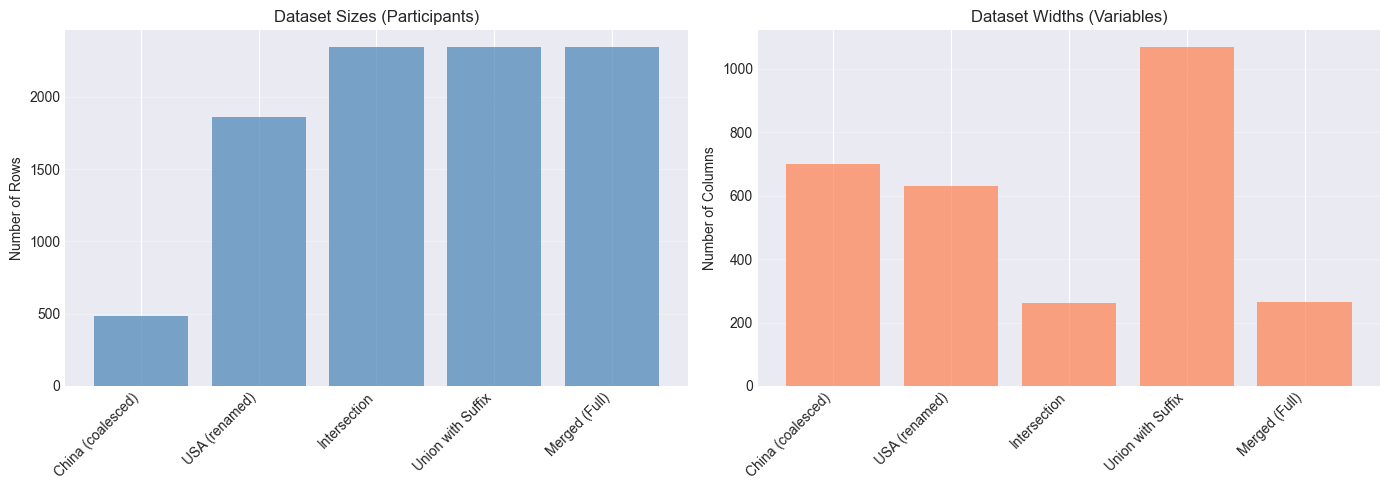


Key observations:
- Intersection has minimal columns (263) - only shared variables
- Union has maximum columns (1068) - all variables with suffixes
- Merged Full has 264 columns - balanced for analysis


In [33]:
# Visualize dataset dimensions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot rows
axes[0].bar(range(len(dataset_summary)), dataset_summary['Rows'], color='steelblue', alpha=0.7)
axes[0].set_xticks(range(len(dataset_summary)))
axes[0].set_xticklabels(dataset_summary['Dataset'], rotation=45, ha='right')
axes[0].set_ylabel('Number of Rows')
axes[0].set_title('Dataset Sizes (Participants)')
axes[0].grid(axis='y', alpha=0.3)

# Plot columns
axes[1].bar(range(len(dataset_summary)), dataset_summary['Columns'], color='coral', alpha=0.7)
axes[1].set_xticks(range(len(dataset_summary)))
axes[1].set_xticklabels(dataset_summary['Dataset'], rotation=45, ha='right')
axes[1].set_ylabel('Number of Columns')
axes[1].set_title('Dataset Widths (Variables)')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nKey observations:")
print(f"- Intersection has minimal columns ({intersection.shape[1]}) - only shared variables")
print(f"- Union has maximum columns ({union_with_suffix.shape[1]}) - all variables with suffixes")
print(f"- Merged Full has {merged.shape[1]} columns - balanced for analysis")

## 4. Data Quality Summary

In [34]:
# Summary by country
print("DATA QUALITY SUMMARY BY COUNTRY")

for country in ['China', 'USA']:
    df_country = merged[merged['Country'] == country]
    print(f" {country} (N={len(df_country)})")
    
    for comp in key_composites:
        if comp in df_country.columns:
            n_valid = df_country[comp].notna().sum()
            mean = df_country[comp].mean()
            std = df_country[comp].std()
            print(f"{comp:20} N={n_valid:4}, M={mean:.2f}, SD={std:.2f}")

DATA QUALITY SUMMARY BY COUNTRY
 China (N=485)
TENS_Life_mean       N= 485, M=4.35, SD=0.99
ET_mean              N= 485, M=4.70, SD=0.91
SSRPH_mean           N= 485, M=2.30, SD=0.93
PHQ5_mean            N= 485, M=1.53, SD=0.99
GAAIS_mean           N= 485, M=4.57, SD=0.69
UTAUT_AI_mean        N= 485, M=3.64, SD=0.55
 USA (N=1857)
TENS_Life_mean       N=1618, M=4.88, SD=1.00
ET_mean              N=1620, M=4.15, SD=0.80
SSRPH_mean           N=1607, M=0.93, SD=0.76
PHQ5_mean            N=1621, M=1.39, SD=1.05
GAAIS_mean           N=1726, M=4.62, SD=0.82
UTAUT_AI_mean        N=1677, M=5.10, SD=1.38


## 4.1 Reliability Analysis (Cronbach's Alpha)

Compute internal consistency reliability for all scales by country

In [35]:
def cronbach_alpha(df, cols):
    """
    Calculate Cronbach's alpha for a set of items
    
    Args:
        df: DataFrame containing the items
        cols: List of column names for the scale items
    
    Returns:
        Cronbach's alpha value (or NaN if cannot compute)
    """
    items = df[cols].dropna()
    
    if len(items) == 0:
        return np.nan
    
    k = items.shape[1]
    if k < 2:
        return np.nan
    
    # Variance of each item
    item_var = items.var(axis=0, ddof=1).sum()
    
    # Variance of total score
    total_var = items.sum(axis=1).var(ddof=1)
    
    if total_var == 0:
        return np.nan
    
    alpha = (k / (k - 1)) * (1 - item_var / total_var)
    return alpha

print("Cronbach's Alpha computation function defined")

Cronbach's Alpha computation function defined


In [36]:
# Define scale item mappings
scale_items = {
    "TENS_Life": ['TENS_Life_1r', 'TENS_Life_2r', 'TENS_Life_3r', 'TENS_Life_4r', 
                  'TENS_Life_5r', 'TENS_Life_6r', 'TENS_Life_7', 'TENS_Life_8', 'TENS_Life_9'],
    "ET": [f'ET_{i}' for i in range(1, 16)],
    "SSRPH": [f'SSRPH_{i}' for i in range(1, 6)],
    "PHQ5": [f'PHQ5_{i}' for i in range(1, 6)],
    "GAAIS": [f'GAAIS_{i}' for i in range(1, 11)],
}

# Add UTAUT subscales for reliability check
utaut_factors = ['EOU', 'SI', 'CONV', 'HC', 'PPR', 'HM', 'TQE']
for factor in utaut_factors:
    # Get item columns for this factor from China data
    factor_cols = []
    for col in cn_coalesced.columns:
        if col.startswith('UTAUT_AI') and any(char.isdigit() for char in col):
            # This is an item column, map to subscale
            if f'UTAUT_AI_{factor}_mean' in cn_coalesced.columns:
                factor_cols.append(col)
    # Will compute reliability on the items used for each subscale

print(f"Defined {len(scale_items)} main scales for reliability analysis")

Defined 5 main scales for reliability analysis


In [37]:
# Compute reliability for merged dataset by country
print("="*70)
print("CRONBACH'S ALPHA RELIABILITY BY COUNTRY")
print("="*70)

for country in ['China', 'USA']:
    print(f"\n{country}:")
    print("-" * 50)
    
    country_data = merged[merged['Country'] == country]
    
    for scale_name, items in scale_items.items():
        # Filter to items that exist in merged dataset
        available_items = [col for col in items if col in country_data.columns]
        
        if len(available_items) >= 2:
            alpha = cronbach_alpha(country_data, available_items)
            n_items = len(available_items)
            n_valid = country_data[available_items].dropna().shape[0]
            
            if not np.isnan(alpha):
                print(f"{scale_name:15} α = {alpha:.3f}  (k={n_items:2}, n={n_valid:4})")
            else:
                print(f"{scale_name:15} α = N/A     (k={n_items:2}, n={n_valid:4})")
        else:
            print(f"{scale_name:15} α = N/A     (insufficient items)")

print("\n" + "="*70)
print("Note: α ≥ 0.70 is generally considered acceptable")
print("      α ≥ 0.80 is good, α ≥ 0.90 is excellent")
print("="*70)

CRONBACH'S ALPHA RELIABILITY BY COUNTRY

China:
--------------------------------------------------
TENS_Life       α = 0.832  (k= 3, n= 485)
ET              α = 0.877  (k=15, n= 485)
SSRPH           α = 0.892  (k= 5, n= 485)
PHQ5            α = 0.881  (k= 5, n= 485)
GAAIS           α = 0.786  (k=10, n= 485)

USA:
--------------------------------------------------
TENS_Life       α = 0.940  (k= 3, n= 507)
ET              α = 0.781  (k=15, n=1620)
SSRPH           α = 0.859  (k= 5, n=1607)
PHQ5            α = 0.890  (k= 5, n=1621)
GAAIS           α = 0.408  (k=10, n=1726)

Note: α ≥ 0.70 is generally considered acceptable
      α ≥ 0.80 is good, α ≥ 0.90 is excellent


## 5. Complete Cases for Hypotheses

In [38]:
# Check complete cases for each hypothesis
print("COMPLETE CASES FOR HYPOTHESES")

hypothesis_vars = {
    'H1: SDT to AI Acceptance': ['TENS_Life_mean', 'UTAUT_AI_mean', 'age', 'gender'],
    'H2: AI Attitude Moderation': ['TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean'],
    'H3: Cross-Cultural': ['TENS_Life_mean', 'UTAUT_AI_mean', 'Country'],
    'H4: ET Mediation': ['TENS_Life_mean', 'ET_mean', 'UTAUT_AI_mean']
}

for hyp, vars_list in hypothesis_vars.items():
    available_vars = [v for v in vars_list if v in merged.columns]
    complete = merged[available_vars].dropna()
    
    print(f"{hyp}")
    print(f"Variables: {', '.join(available_vars)}")
    print(f"Complete cases: {len(complete):4} / {len(merged)} ({len(complete)/len(merged)*100:.1f}%)")
    
    # Breakdown by country
    if 'Country' in complete.columns:
        for country in ['China', 'USA']:
            n = len(complete[complete['Country'] == country])
            print(f"{country}: {n:4}")

COMPLETE CASES FOR HYPOTHESES
H1: SDT to AI Acceptance
Variables: TENS_Life_mean, UTAUT_AI_mean, age, gender
Complete cases: 2096 / 2342 (89.5%)
H2: AI Attitude Moderation
Variables: TENS_Life_mean, UTAUT_AI_mean, GAAIS_mean
Complete cases: 2096 / 2342 (89.5%)
H3: Cross-Cultural
Variables: TENS_Life_mean, UTAUT_AI_mean, Country
Complete cases: 2096 / 2342 (89.5%)
China:  485
USA: 1611
H4: ET Mediation
Variables: TENS_Life_mean, ET_mean, UTAUT_AI_mean
Complete cases: 2096 / 2342 (89.5%)


## 5.1 Missing Data Imputation

Use IterativeImputer to handle missing data in key hypothesis variables

In [39]:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer

# Key variables for hypothesis testing
h_vars = [
    'TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean',
    'ET_mean', 'PHQ5_mean', 'SSRPH_mean',
    'age'
]

# Check completeness before imputation
print("Missing data summary before imputation:")
print("-" * 50)
for var in h_vars:
    if var in merged.columns:
        n_missing = merged[var].isna().sum()
        pct_missing = (n_missing / len(merged)) * 100
        print(f"{var:20} {n_missing:4} missing ({pct_missing:5.1f}%)")

# Complete cases before imputation
complete_before = merged[h_vars].dropna()
print(f"\nComplete cases (listwise deletion): {len(complete_before)} / {len(merged)} ({len(complete_before)/len(merged)*100:.1f}%)")

Missing data summary before imputation:
--------------------------------------------------
TENS_Life_mean        239 missing ( 10.2%)
UTAUT_AI_mean         180 missing (  7.7%)
GAAIS_mean            131 missing (  5.6%)
ET_mean               237 missing ( 10.1%)
PHQ5_mean             236 missing ( 10.1%)
SSRPH_mean            250 missing ( 10.7%)
age                   115 missing (  4.9%)

Complete cases (listwise deletion): 2085 / 2342 (89.0%)


In [40]:
# Prepare data for imputation
# Need to encode categorical variables (gender, Country)
impute_vars = h_vars + ['gender', 'Country']
impute_df = merged[impute_vars].copy()

# One-hot encode categoricals
impute_df_encoded = pd.get_dummies(impute_df, columns=['gender', 'Country'], drop_first=True)

print(f"Imputation dataset shape: {impute_df_encoded.shape}")
print(f"Variables: {list(impute_df_encoded.columns)}")

# Initialize imputer
imputer = IterativeImputer(random_state=42, max_iter=10)

print("\nRunning iterative imputation...")
imputed_array = imputer.fit_transform(impute_df_encoded)

# Convert back to DataFrame
merged_imputed = pd.DataFrame(imputed_array, columns=impute_df_encoded.columns, index=merged.index)

# Decode gender and Country back from dummy variables
# Keep the continuous variables
for var in h_vars:
    merged[f'{var}_imputed'] = merged_imputed[var]

print("✓ Imputation complete")
print(f"\nImputed variables created: {[f'{v}_imputed' for v in h_vars]}")

Imputation dataset shape: (2342, 11)
Variables: ['TENS_Life_mean', 'UTAUT_AI_mean', 'GAAIS_mean', 'ET_mean', 'PHQ5_mean', 'SSRPH_mean', 'age', 'gender_2.0', 'gender_3.0', 'gender_4.0', 'Country_USA']

Running iterative imputation...
✓ Imputation complete

Imputed variables created: ['TENS_Life_mean_imputed', 'UTAUT_AI_mean_imputed', 'GAAIS_mean_imputed', 'ET_mean_imputed', 'PHQ5_mean_imputed', 'SSRPH_mean_imputed', 'age_imputed']


In [41]:
# Compare distributions before/after imputation
print("\nComparison of means before/after imputation:")
print("=" * 60)
print(f"{'Variable':20} {'Original':>12} {'Imputed':>12} {'Diff':>10}")
print("-" * 60)

for var in h_vars:
    if var in merged.columns:
        orig_mean = merged[var].mean()
        imp_mean = merged[f'{var}_imputed'].mean()
        diff = imp_mean - orig_mean
        print(f"{var:20} {orig_mean:12.3f} {imp_mean:12.3f} {diff:10.3f}")

print("=" * 60)
print("Note: Small differences indicate imputation did not drastically")
print("      change the data distribution")


Comparison of means before/after imputation:
Variable                 Original      Imputed       Diff
------------------------------------------------------------
TENS_Life_mean              4.759        4.775      0.016
UTAUT_AI_mean               4.776        4.797      0.021
GAAIS_mean                  4.611        4.608     -0.003
ET_mean                     4.273        4.253     -0.020
PHQ5_mean                   1.422        1.414     -0.008
SSRPH_mean                  1.246        1.208     -0.038
age                        34.159       34.464      0.306
Note: Small differences indicate imputation did not drastically
      change the data distribution


# 6. Hypothesis Testing set up

In [42]:
# Work on a copy to avoid modifying the original merged dataframe
df = merged.copy()

# inspect basic structure of key variables
print("Columns available for hypotheses:")
print([c for c in df.columns if c in [
    "TENS_Life_mean", "UTAUT_AI_mean", "GAAIS_mean", "ET_mean",
    "PHQ5_mean", "SSRPH_mean", "age", "gender", "Country"
]])

Columns available for hypotheses:
['Country', 'ET_mean', 'GAAIS_mean', 'PHQ5_mean', 'SSRPH_mean', 'TENS_Life_mean', 'UTAUT_AI_mean', 'age', 'gender']


In [43]:
# Center continuous predictors for moderation/mediation
for col in ["TENS_Life_mean", "GAAIS_mean", "ET_mean", "age"]:
    if col in df.columns:
        df[col + "_c"] = df[col] - df[col].mean()
        
print("Centered variables created: ", [c for c in df.columns if c.endswith("_c")])

Centered variables created:  ['TENS_Life_mean_c', 'GAAIS_mean_c', 'ET_mean_c', 'age_c']


In [44]:
# H1 — Main Effect: SDT (TENS_Life_mean) → AI Acceptance (UTAUT_AI_mean)

h1_vars = ["TENS_Life_mean", "UTAUT_AI_mean", "age", "gender", "Country"]
h1_df = df[h1_vars].dropna().copy()

print(f"H1 sample size (complete cases): N = {len(h1_df)}")

# 1) Pearson correlation between SDT and AI Acceptance
r, p = stats.pearsonr(h1_df["TENS_Life_mean"], h1_df["UTAUT_AI_mean"])
print(f"\nPearson r(TENS_Life_mean, UTAUT_AI_mean) = {r:.3f}, p = {p:.4g}")

# 2) OLS regression with age & gender as controls
# gender is treated as categorical (C(gender))
h1_model = smf.ols(
    formula="UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)",
    data=h1_df
).fit()

print("\nH1 Regression Summary: UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)")
print(h1_model.summary())


H1 sample size (complete cases): N = 2096

Pearson r(TENS_Life_mean, UTAUT_AI_mean) = 0.160, p = 1.947e-13

H1 Regression Summary: UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     21.80
Date:                Tue, 25 Nov 2025   Prob (F-statistic):           2.45e-21
Time:                        10:59:39   Log-Likelihood:                -3600.9
No. Observations:                2096   AIC:                             7214.
Df Residuals:                    2090   BIC:                             7248.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                       coef   

In [45]:
# H2 — Attitudinal Moderation: TENS_Life_mean × GAAIS_mean

h2_vars = [
    "UTAUT_AI_mean",
    "TENS_Life_mean_c",
    "GAAIS_mean_c",
    "age_c",         # centered age
    "gender",
    "Country"
]

# Make sure centered age exists; if not, fallback to raw age
if "age_c" not in df.columns and "age" in df.columns:
    df["age_c"] = df["age"] - df["age"].mean()

h2_df = df[h2_vars].dropna().copy()
print(f"H2 sample size (complete cases): N = {len(h2_df)}")

# Interaction model: SDT × GAAIS_mean
h2_model = smf.ols(
    formula=(
        "UTAUT_AI_mean ~ "
        "TENS_Life_mean_c * GAAIS_mean_c "
        "+ age_c + C(gender) + C(Country)"
    ),
    data=h2_df
).fit()

print("\nH2 Moderation Regression Summary:")
print("Model: UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c + age_c + C(gender) + C(Country)")
print(h2_model.summary())


H2 sample size (complete cases): N = 2096

H2 Moderation Regression Summary:
Model: UTAUT_AI_mean ~ TENS_Life_mean_c * GAAIS_mean_c + age_c + C(gender) + C(Country)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     97.21
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          1.13e-137
Time:                        10:59:39   Log-Likelihood:                -3322.3
No. Observations:                2096   AIC:                             6663.
Df Residuals:                    2087   BIC:                             6713.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                    coef    s

In [46]:
# H3 — Cross-Cultural Moderation: TENS_Life_mean × Country (China vs USA)

h3_vars = [
    "UTAUT_AI_mean",
    "TENS_Life_mean_c",
    "age_c",
    "gender",
    "Country"
]

h3_df = df[h3_vars].dropna().copy()
print(f"H3 sample size (complete cases): N = {len(h3_df)}")

# Check country distribution
print("\nH3 Country breakdown:")
print(h3_df["Country"].value_counts())

h3_model = smf.ols(
    formula=(
        "UTAUT_AI_mean ~ "
        "TENS_Life_mean_c * C(Country) "
        "+ age_c + C(gender)"
    ),
    data=h3_df
).fit()

print("\nH3 Cross-Cultural Moderation Summary:")
print("Model: UTAUT_AI_mean ~ TENS_Life_mean_c * C(Country) + age_c + C(gender)")
print(h3_model.summary())


H3 sample size (complete cases): N = 2096

H3 Country breakdown:
Country
USA      1611
China     485
Name: count, dtype: int64

H3 Cross-Cultural Moderation Summary:
Model: UTAUT_AI_mean ~ TENS_Life_mean_c * C(Country) + age_c + C(gender)
                            OLS Regression Results                            
Dep. Variable:          UTAUT_AI_mean   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     105.5
Date:                Tue, 25 Nov 2025   Prob (F-statistic):          1.71e-132
Time:                        10:59:40   Log-Likelihood:                -3336.7
No. Observations:                2096   AIC:                             6689.
Df Residuals:                    2088   BIC:                             6735.
Df Model:                           7                                         
Covariance Type:            nonrobust             

In [47]:
# H4 — Mediation: TENS_Life_mean → ET_mean → UTAUT_AI_mean

h4_vars = [
    "TENS_Life_mean_c",
    "ET_mean_c",
    "UTAUT_AI_mean",
    "age_c",
    "gender",
    "Country"
]

# Ensure centered ET exists
if "ET_mean_c" not in df.columns and "ET_mean" in df.columns:
    df["ET_mean_c"] = df["ET_mean"] - df["ET_mean"].mean()

h4_df = df[h4_vars].dropna().copy()
print(f"H4 sample size (complete cases): N = {len(h4_df)}")

# Path a: ET_mean_c ~ TENS_Life_mean_c + controls
a_model = smf.ols(
    formula="ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender) + C(Country)",
    data=h4_df
).fit()

print("\nH4 Path a (TENS_Life_mean_c → ET_mean_c):")
print(a_model.summary().tables[1])

# Path b + c': UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + controls
b_model = smf.ols(
    formula="UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender) + C(Country)",
    data=h4_df
).fit()

print("\nH4 Path b + c' (ET_mean_c and TENS_Life_mean_c → UTAUT_AI_mean):")
print(b_model.summary().tables[1])

# Extract coefficients for a and b
a_coef = a_model.params["TENS_Life_mean_c"]
b_coef = b_model.params["ET_mean_c"]
print(f"\nPoint estimate of indirect effect (a * b) = {a_coef * b_coef:.4f}")

# --- Simple bootstrap for indirect effect ---
n_boot = 5000
boot_indirect = []

n = len(h4_df)
for _ in range(n_boot):
    sample_idx = np.random.choice(n, size=n, replace=True)
    sample = h4_df.iloc[sample_idx]
    
    a_m = smf.ols(
        formula="ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender) + C(Country)",
        data=sample
    ).fit()
    
    b_m = smf.ols(
        formula="UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender) + C(Country)",
        data=sample
    ).fit()
    
    a_b = a_m.params.get("TENS_Life_mean_c", np.nan)
    b_b = b_m.params.get("ET_mean_c", np.nan)
    
    if not np.isnan(a_b) and not np.isnan(b_b):
        boot_indirect.append(a_b * b_b)

boot_indirect = np.array(boot_indirect)
indirect_mean = np.mean(boot_indirect)
ci_lower, ci_upper = np.percentile(boot_indirect, [2.5, 97.5])

print(f"\nBootstrapped indirect effect (a*b): mean = {indirect_mean:.4f}")
print(f"95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Number of successful bootstrap samples: {len(boot_indirect)} / {n_boot}")


H4 sample size (complete cases): N = 2096

H4 Path a (TENS_Life_mean_c → ET_mean_c):
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1896      0.052      3.632      0.000       0.087       0.292
C(gender)[T.2.0]      0.0599      0.037      1.633      0.103      -0.012       0.132
C(gender)[T.3.0]      0.0340      0.126      0.269      0.788      -0.214       0.282
C(gender)[T.4.0]     -0.3645      0.311     -1.174      0.241      -0.974       0.245
C(Country)[T.USA]    -0.2864      0.059     -4.870      0.000      -0.402      -0.171
TENS_Life_mean_c     -0.0549      0.018     -3.031      0.002      -0.090      -0.019
age_c                -0.0083      0.001     -5.692      0.000      -0.011      -0.005

H4 Path b + c' (ET_mean_c and TENS_Life_mean_c → UTAUT_AI_mean):
                        coef    std err          t      P>|t|      [0.025  

### H1 Enhancement: Correlations with UTAUT Subscales

Test correlations between TENS_Life_mean and each UTAUT subscale

In [48]:
# Get all UTAUT subscale columns
utaut_subscales = [c for c in merged.columns if 'UTAUT_' in c and c.endswith('_mean') and 
                   any(factor in c for factor in ['EOU', 'SI', 'CONV', 'HC', 'PPR', 'HM', 'TQE'])]

if utaut_subscales:
    print("H1 Enhancement: TENS_Life_mean Correlations with UTAUT Subscales")
    print("="*70)
    print(f"{'Subscale':30} {'r':>8} {'p':>10} {'N':>8} {'Strength':>12}")
    print("-"*70)
    
    for subscale in sorted(utaut_subscales):
        # Compute correlation
        valid_data = merged[['TENS_Life_mean', subscale]].dropna()
        if len(valid_data) > 10:
            r, p = stats.pearsonr(valid_data['TENS_Life_mean'], valid_data[subscale])
            
            # Interpretation
            if abs(r) >= 0.5:
                strength = "Strong"
            elif abs(r) >= 0.3:
                strength = "Moderate"
            elif abs(r) >= 0.1:
                strength = "Weak"
            else:
                strength = "Very weak"
            
            print(f"{subscale:30} {r:8.3f} {p:10.4g} {len(valid_data):8} {strength:>12}")
    
    print("="*70)
    print("Note: |r| ≥ 0.3 = moderate, |r| ≥ 0.5 = strong correlation")
else:
    print("No UTAUT subscales found in merged dataset")
    print("This is expected if subscales were only computed within country-specific datasets")

No UTAUT subscales found in merged dataset
This is expected if subscales were only computed within country-specific datasets


In [49]:
# Visualize correlations with heatmap (if subscales exist)
if utaut_subscales and len(utaut_subscales) > 0:
    import seaborn as sns
    
    # Prepare correlation matrix
    corr_vars = ['TENS_Life_mean'] + utaut_subscales[:7]  # Limit to 7 subscales for visibility
    corr_data = merged[corr_vars].corr()
    
    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_data, annot=True, fmt='.2f', cmap='RdBu_r', 
                center=0, vmin=-1, vmax=1, square=True, cbar_kws={'label': 'Correlation'})
    plt.title('Correlation Matrix: TENS_Life and UTAUT Subscales', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
else:
    print("Skipping heatmap - no subscales available")

Skipping heatmap - no subscales available


### H2 Enhancement: Simple Slopes Analysis

Probe the TENS × GAAIS interaction at low/mean/high levels of GAAIS

In [50]:
# Simple slopes at -1 SD, Mean, +1 SD of GAAIS
if 'GAAIS_mean' in h2_df.columns:
    gaais_mean = h2_df['GAAIS_mean'].mean()
    gaais_sd = h2_df['GAAIS_mean'].std()
    
    levels = {
        'Low (-1 SD)': gaais_mean - gaais_sd,
        'Mean': gaais_mean,
        'High (+1 SD)': gaais_mean + gaais_sd
    }
    
    print("H2 Simple Slopes: Effect of TENS_Life on UTAUT at Different GAAIS Levels")
    print("="*70)
    
    # Get coefficients from h2_model
    b_tens = h2_model.params.get('TENS_Life_mean_c', 0)
    b_interaction = h2_model.params.get('TENS_Life_mean_c:GAAIS_mean_c', 0)
    
    print(f"{'GAAIS Level':20} {'GAAIS Value':>12} {'Simple Slope':>15}")
    print("-"*70)
    
    for level_name, gaais_val in levels.items():
        # Simple slope = b_tens + b_interaction * (gaais_val - gaais_mean)
        simple_slope = b_tens + b_interaction * (gaais_val - gaais_mean)
        print(f"{level_name:20} {gaais_val:12.3f} {simple_slope:15.4f}")
    
    print("="*70)
    print(f"Interaction term: {b_interaction:.4f} (p={h2_model.pvalues.get('TENS_Life_mean_c:GAAIS_mean_c', 1):.3f})")

In [51]:
# Visualize interaction
if 'GAAIS_mean' in h2_df.columns and 'TENS_Life_mean' in h2_df.columns:
    # Create categorical GAAIS groups for visualization
    gaais_terciles = pd.qcut(h2_df['GAAIS_mean'], q=3, labels=['Low', 'Medium', 'High'])
    h2_df['GAAIS_group'] = gaais_terciles
    
    plt.figure(figsize=(10, 6))
    
    for group in ['Low', 'Medium', 'High']:
        group_data = h2_df[h2_df['GAAIS_group'] == group]
        if len(group_data) > 10:
            # Fit simple regression for this group
            X = sm.add_constant(group_data['TENS_Life_mean'])
            y = group_data['UTAUT_AI_mean']
            model = sm.OLS(y, X, missing='drop').fit()
            
            # Plot
            x_range = np.linspace(group_data['TENS_Life_mean'].min(), 
                                 group_data['TENS_Life_mean'].max(), 100)
            y_pred = model.params[0] + model.params[1] * x_range
            plt.plot(x_range, y_pred, label=f'GAAIS {group}', linewidth=2)
    
    plt.xlabel('TENS_Life_mean (SDT)', fontsize=12)
    plt.ylabel('UTAUT_AI_mean (AI Acceptance)', fontsize=12)
    plt.title('H2: TENS × GAAIS Interaction on AI Acceptance', fontsize=14, pad=15)
    plt.legend(title='AI Attitudes (GAAIS)', fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

### H3 Enhancement: Role-Specific Analysis (Client vs Therapist)

Test if the SDT → AI Acceptance relationship differs by role within China

In [52]:
# Check if role_label is available in merged dataset
if 'role_label' in merged.columns:
    china_data = merged[merged['Country'] == 'China'].copy()
    
    print("H3 Enhancement: Role-Specific Analysis (China Only)")
    print("="*70)
    
    # Check role distribution
    print("\nRole distribution in China:")
    print(china_data['role_label'].value_counts())
    
    # Test TENS × role interaction
    role_vars = ['UTAUT_AI_mean', 'TENS_Life_mean', 'age', 'gender', 'role_label']
    china_role_df = china_data[role_vars].dropna()
    
    if len(china_role_df) > 50:
        # Center TENS for China subset
        china_role_df['TENS_c'] = china_role_df['TENS_Life_mean'] - china_role_df['TENS_Life_mean'].mean()
        china_role_df['age_c'] = china_role_df['age'] - china_role_df['age'].mean()
        
        # Fit model with role interaction
        role_model = smf.ols(
            formula='UTAUT_AI_mean ~ TENS_c * C(role_label) + age_c + C(gender)',
            data=china_role_df
        ).fit()
        
        print("\n" + "="*70)
        print("Model: UTAUT ~ TENS × role_label + age + gender (China only)")
        print("="*70)
        print(role_model.summary())
    else:
        print("\nInsufficient data for role analysis")
else:
    print("Role-specific analysis not possible: 'role_label' not in merged dataset")
    print("Note: role_label exists in cn_coalesced but was not included in merge")

Role-specific analysis not possible: 'role_label' not in merged dataset
Note: role_label exists in cn_coalesced but was not included in merge


In [53]:
# Compare slopes by role
if 'role_label' in merged.columns:
    china_data = merged[merged['Country'] == 'China']
    
    print("\nSimple slopes by role (China):")
    print("-"*70)
    
    for role in ['client', 'therapist']:
        role_data = china_data[china_data['role_label'] == role]
        role_complete = role_data[['TENS_Life_mean', 'UTAUT_AI_mean', 'age', 'gender']].dropna()
        
        if len(role_complete) > 20:
            model = smf.ols(
                formula='UTAUT_AI_mean ~ TENS_Life_mean + age + C(gender)',
                data=role_complete
            ).fit()
            
            beta = model.params.get('TENS_Life_mean', np.nan)
            p_val = model.pvalues.get('TENS_Life_mean', 1)
            
            print(f"{role.capitalize():15} β = {beta:7.4f}, p = {p_val:.4f}, N = {len(role_complete)}")
    
    print("="*70)

### H4 Enhancement: Mediation Analysis by Country

Test if the indirect effect (TENS → ET → UTAUT) differs between China and USA

In [54]:
# Run mediation separately by country
print("H4 Enhancement: Country-Specific Mediation Analysis")
print("="*70)

mediation_results = {}

for country in ['China', 'USA']:
    country_data = h4_df[h4_df['Country'] == country].copy()
    
    if len(country_data) < 50:
        print(f"\n{country}: Insufficient data (N={len(country_data)})")
        continue
    
    print(f"\n{country} (N={len(country_data)}):")
    print("-"*70)
    
    # Path a: TENS → ET
    a_model_c = smf.ols(
        formula='ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender)',
        data=country_data
    ).fit()
    
    # Path b+c': TENS + ET → UTAUT
    b_model_c = smf.ols(
        formula='UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender)',
        data=country_data
    ).fit()
    
    # Extract coefficients
    a_coef = a_model_c.params.get('TENS_Life_mean_c', 0)
    b_coef = b_model_c.params.get('ET_mean_c', 0)
    c_prime = b_model_c.params.get('TENS_Life_mean_c', 0)
    
    # Indirect effect
    indirect = a_coef * b_coef
    
    # Bootstrap CI
    n_boot = 1000
    boot_indirect = []
    
    for _ in range(n_boot):
        sample = country_data.sample(n=len(country_data), replace=True)
        try:
            a_m = smf.ols('ET_mean_c ~ TENS_Life_mean_c + age_c + C(gender)', data=sample).fit()
            b_m = smf.ols('UTAUT_AI_mean ~ TENS_Life_mean_c + ET_mean_c + age_c + C(gender)', data=sample).fit()
            boot_indirect.append(a_m.params.get('TENS_Life_mean_c', 0) * b_m.params.get('ET_mean_c', 0))
        except:
            pass
    
    if boot_indirect:
        ci_lower, ci_upper = np.percentile(boot_indirect, [2.5, 97.5])
        
        print(f"  Path a (TENS → ET):        {a_coef:7.4f}")
        print(f"  Path b (ET → UTAUT):       {b_coef:7.4f}")
        print(f"  Path c' (TENS → UTAUT):    {c_prime:7.4f}")
        print(f"  Indirect effect (a × b):   {indirect:7.4f}")
        print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
        
        # Check if CI excludes zero
        sig = "***" if (ci_lower > 0 or ci_upper < 0) else "ns"
        print(f"  Significance: {sig}")
        
        mediation_results[country] = {
            'a': a_coef,
            'b': b_coef,
            'c_prime': c_prime,
            'indirect': indirect,
            'ci': (ci_lower, ci_upper)
        }

print("\n" + "="*70)

H4 Enhancement: Country-Specific Mediation Analysis

China (N=485):
----------------------------------------------------------------------
  Path a (TENS → ET):         0.5163
  Path b (ET → UTAUT):        0.1685
  Path c' (TENS → UTAUT):     0.2095
  Indirect effect (a × b):    0.0870
  95% CI: [0.0532, 0.1254]
  Significance: ***

USA (N=1611):
----------------------------------------------------------------------
  Path a (TENS → ET):        -0.2290
  Path b (ET → UTAUT):        0.2491
  Path c' (TENS → UTAUT):     0.1072
  Indirect effect (a × b):   -0.0570
  95% CI: [-0.0829, -0.0362]
  Significance: ***



In [55]:
# Compare indirect effects across countries
if len(mediation_results) == 2:
    print("\nComparison of Indirect Effects:")
    print("="*70)
    print(f"{'Country':15} {'Indirect Effect':>18} {'95% CI':>25}")
    print("-"*70)
    
    for country, res in mediation_results.items():
        ci_str = f"[{res['ci'][0]:.4f}, {res['ci'][1]:.4f}]"
        print(f"{country:15} {res['indirect']:18.4f} {ci_str:>25}")
    
    print("="*70)
    print("Note: Non-overlapping CIs suggest different mediation effects")


Comparison of Indirect Effects:
Country            Indirect Effect                    95% CI
----------------------------------------------------------------------
China                       0.0870          [0.0532, 0.1254]
USA                        -0.0570        [-0.0829, -0.0362]
Note: Non-overlapping CIs suggest different mediation effects


## 🎉 Analysis-Ready Datasets Created!

Two clean datasets have been created:

1. **`data/china/CN_all_coalesced.csv`** - China data with:
   - Client and therapist data merged
   - All composite scores computed
   - Ready for China-specific analyses

2. **`data/merged/merged.csv`** - Combined USA + China data with:
   - Only common variables across countries
   - All key composite scores
   - Ready for hypothesis testing (H1-H4)

### Key Variables Available:
- **TENS_Life_mean** - Self-Determination (SDT)
- **UTAUT_AI_mean** - AI Acceptance
- **GAAIS_mean** - General AI Attitudes
- **ET_mean** - Epistemic Trust  
- **SSRPH_mean** - Stigma
- **PHQ5_mean** - Depression
- **Country** - USA / China
- **age, gender, edu** - Demographics

### Next Steps:
Use `merged.csv` for all hypothesis testing!